In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import cv2
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import make_grid

# Prepare data and Load data

In [5]:
# Defines the root folders of our potato data
from dataclasses import dataclass
@dataclass
class Config:
    root_dir = '/kaggle/input/plantvillage-dataset/color'
    potato = [os.path.join('/kaggle/input/plantvillage-dataset/color', i)
              for i in os.listdir('/kaggle/input/plantvillage-dataset/color')
              if i.startswith('Po')]
cfg = Config()

In [6]:
# Load the data of potaoes from the storage
class LoadData(Dataset):
    def __init__(self, folders, transform=None, shuffle = False, train_size=0.8, train=True):
        self.folders = folders
        self.images = self.prep_folders(self.folders)
        random.seed(42)
        random.shuffle(self.images) if shuffle else self.images
        self.images = self.images[:int(train_size*len(self.images))] if train else self.images[int(train_size*len(self.images)):]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, label= self.read_image(self.images[idx])
        if self.transform:
            return self.transform(img), label
        return torch.from_numpy(img), label
        
    
    def prep_folders(self, folders):
        temp = []
        for path in folders:
            temp.extend(os.path.join(path, i) for i in os.listdir(path))
        return temp
    
    def read_image(self, path):
        try:
            img = cv2.imread(path)
            label = os.path.split(path)[0]
            labels = self.folders.index(label)
            return img, labels
        except Exception as e:
            print(e)


In [7]:
# Define the training data augmentation 
train_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomHorizontalFlip(0.5),
                                     transforms.RandomVerticalFlip(0.5),]
                    )
train_data = LoadData(cfg.potato, shuffle=True, transform=train_transforms)
test_data = LoadData(cfg.potato, shuffle=True, transform=transforms.ToTensor(), train=False)

In [8]:
# get the number images in each class
count={}
for i in test_data:
    if i[1] in count:
        count[i[1]]+=1
    else:
        count[i[1]]=0
train_count={}
for i in train_data:
    if i[1] in train_count:
        train_count[i[1]]+=1
    else:
        train_count[i[1]]=0
        
print(f"Training data {train_count}, Testing data {count}")

Training data {2: 810, 1: 790, 0: 118}, Testing data {2: 188, 1: 208, 0: 32}


In [9]:
# If data is balanced, size of each image etc
for test, train in zip(count, train_count):
    print(f"Number of images for class {test} are {count[test]+train_count[train]}")

# Check the shape of the images
for i in train_data:
    assert i[0].shape == (3,256,256)
for i in test_data:
    assert i[0].shape == (3,256,256)
    
# Check if the image i normalised bw [0-1]
random_image = train_data[random.randint(0, len(train_data))][0]
print(f"Min value of image is {random_image.min()} and max value is  {random_image.max()}")

Number of images for class 2 are 998
Number of images for class 1 are 998
Number of images for class 0 are 150
Min value of image is 0.0 and max value is  1.0


# Observations of the data set
1. Image data is not balanced images for class 0 are 150 where other two have 1000 each
2. Shape of all the images is same (3,256,256)
3. The value of the image is between [0, 1]


In [10]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

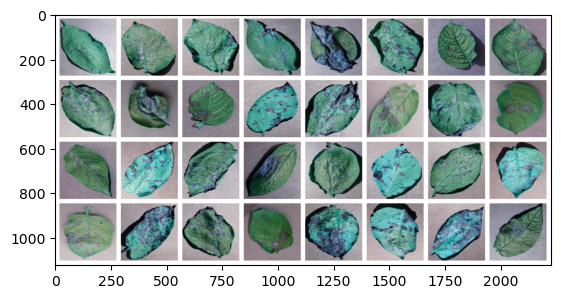

In [11]:
img = make_grid(next(iter(train_dataloader))[0], padding=20, nrow=8, pad_value=1)
plt.imshow(img.permute(1,2,0))

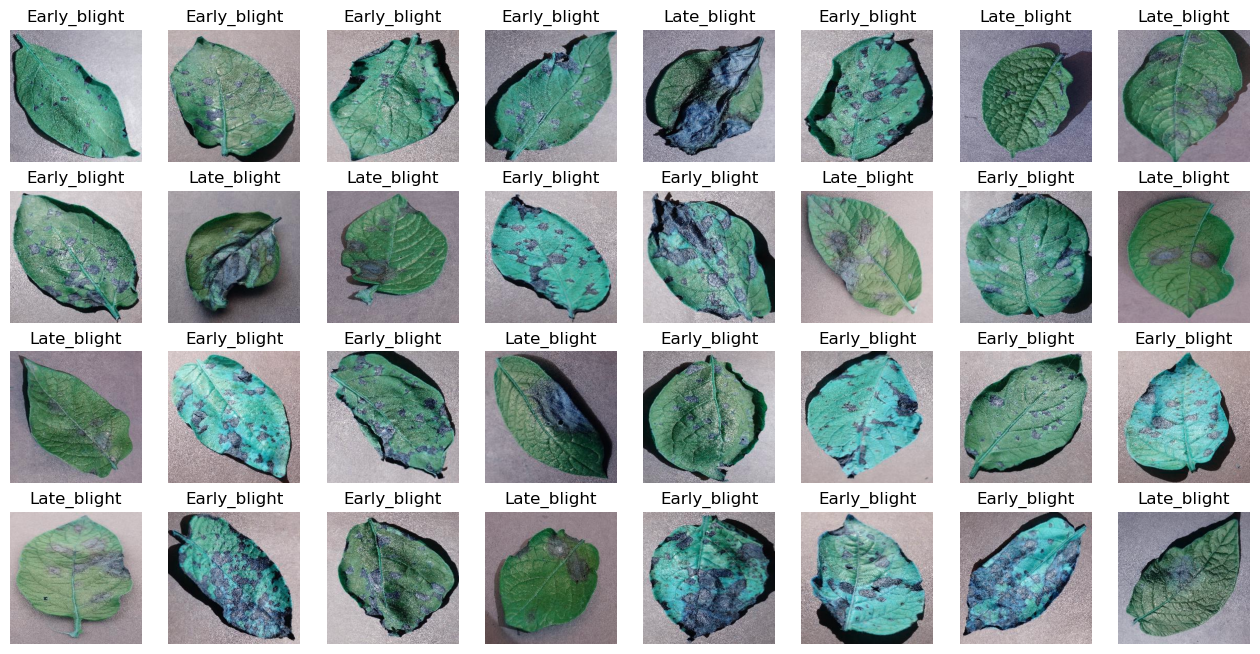

In [12]:
fig = plt.figure(figsize=(16,8))
for idx,  (X, y) in enumerate(train_data):
    if idx >= 32:
        break
    sub_image = fig.add_subplot(4,8, idx+1)
    sub_image.imshow(X.permute(1,2,0))
    sub_image.set_title(cfg.potato[y].split('/')[-1].split('___')[1])
    sub_image.axis('off')

    

# Define the CNN model

In [13]:
class CNNPotato(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,stride=1, padding=0, kernel_size=3 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=len(cfg.potato))
        )
    def conv_operation(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        return x
    def classifier(self, x):
        x = self.dense(x)
        return x
    
    def forward(self, x):
        x = self.conv_operation(x)
        x = self.classifier(x)
        
        return x
model = CNNPotato()
model

CNNPotato(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block6): Sequential(
    (0): Conv2d(64, 64, kernel_

In [14]:
# Make a random image of shape(3,256,256)
# using torch.cat()
# im = torch.cat([torch.tensor(np.random.rand(256, 256), dtype=torch.float32).unsqueeze(dim=0),
#                 torch.tensor(np.random.rand(256, 256), dtype=torch.float32).unsqueeze(dim=0),
#                 torch.tensor(np.random.rand(256, 256), dtype=torch.float32).unsqueeze(dim=0)])
im = torch.tensor(np.random.rand(3,256,256), dtype=torch.float32)
im.unsqueeze(dim=0).shape

torch.Size([1, 3, 256, 256])

In [15]:
# pass image through convs to check output shape
model.conv_operation(im.unsqueeze(dim=0)).shape

torch.Size([1, 64, 2, 2])

In [16]:
# pass thorught the flat layer to check the shape
nn.Flatten()(model(im.unsqueeze(dim=0))).shape

torch.Size([1, 3])

# Train, test function


## Train step to perform training


In [17]:
# modular train_step
from tqdm.auto import tqdm
def train_step(
    model: torch.nn.Module,
    dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device:torch.device
):
    # Put model in train mode
    model.train()
    
    # Setup loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Loop throught the data
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Send data to device gpu or cpu
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate accuracy across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/ len(y_pred)
        
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    
    return train_loss, train_acc

## Test step for model validation

In [18]:

#  create test step
def test_step(model: torch.nn.Module,
    dataloader,
    loss_fn: torch.nn.Module,
    device: torch.device
):
    # Put model in eval mode
    model.eval()
    
    # Setup test loss and accuracy
    test_loss, test_acc = 0, 0
    
    # Inference mode or with torch.no_grad()
    with torch.inference_mode():
        # Loop through data
        for batch, (X, y) in enumerate(dataloader):
            # Send code to device
            X , y = X.to(device), y.to(device)
        
            # 1. Forward pass
            test_pred = model.forward(X)
            
            # 2. Calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
            # 3. Calculate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Train function to loop through data (epochs) and perform training and validation

In [19]:
def train(
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    lr_degrade=False
):
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    milestones = [2, 5, 15]  # epochs at which to change the learning rate
    lr_values = [0.01, 0.001, 0.0006]  # learning rates to use after each milestone
    # Loop through data or epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        if lr_degrade:
            if epoch in milestones:
                lr_index = milestones.index(epoch)
                new_lr = lr_values[lr_index]
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr

        
        # Test the model on unseen data
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device
                                       )
        
        
        # Print the loss and accuracy
        print(f"Epoch {epoch+1} ===> ",
              f"Train_loss {train_loss:.4f} ===> ",
              f"Train_acc {train_acc:.4f} ===> ",
              f"Test_loss {test_loss:.4f} ===> ",
              f"Test_acc {test_acc:.4f}"
        )
        
        # update the results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

## Save model function 

In [20]:
from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## Actual function where all of the above train, save model function is called
* set device
* set number of epochs
* create model
* define loss and optimizer functions
* train the model by calling train()
* save the model after the training process is finished

In [24]:
from timeit import default_timer as timer
from torch.optim.lr_scheduler import MultiStepLR

def initiate_training(lr_degrade=False):
    # Set random seeds
    torch.manual_seed(42) 
    torch.cuda.manual_seed(42)
    
    # Set up device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Avilable device is {device}")
    
    # Set number of epochs
    EPOCHS = 30

    # Create model instance
    model = CNNPotato().to(device)
    
    # For imbalanced dataset
    weights = torch.tensor([1/150, 1/1000, 1/1000])
    weights = weights / weights.sum() 
    
    # Setup loss function and optimizer
    # Set weights in the loss function for imbalanced data
    loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0006)
    
    milestones = [2, 5, 15]
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1, last_epoch=-1)
    
    # Start the timer 
    start_time = timer()
    
    # Train model_0 
    model_results = train(model=model, 
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn, 
                            epochs=EPOCHS,
                            device=device,
                            lr_degrade = lr_degrade 
                           )

    # End the timer and print out how long it took
    end_time = timer()
    print('\n---------------------------------------------------------------------------------------\n')
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
    print('\n---------------------------------------------------------------------------------------\n')
    # Save the model
    save_model(model=model,
               target_dir="",
               model_name="CNN-potato-disease.pth")
    return model_results

# Initiate the training 

In [25]:
results = initiate_training(lr_degrade = False)

Avilable device is cuda


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.0747 ===>  Train_acc 0.5484 ===>  Test_loss 0.9467 ===>  Test_acc 0.7153


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 0.8061 ===>  Train_acc 0.6800 ===>  Test_loss 0.6348 ===>  Test_acc 0.6472


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 0.5759 ===>  Train_acc 0.6841 ===>  Test_loss 0.4586 ===>  Test_acc 0.7259


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 0.4442 ===>  Train_acc 0.7985 ===>  Test_loss 0.4061 ===>  Test_acc 0.7865


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 0.3783 ===>  Train_acc 0.8279 ===>  Test_loss 0.3884 ===>  Test_acc 0.7842


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 0.3518 ===>  Train_acc 0.8324 ===>  Test_loss 0.3631 ===>  Test_acc 0.8132


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 0.3155 ===>  Train_acc 0.8396 ===>  Test_loss 0.3248 ===>  Test_acc 0.8199


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 0.2989 ===>  Train_acc 0.8562 ===>  Test_loss 0.3172 ===>  Test_acc 0.8199


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 0.2978 ===>  Train_acc 0.8593 ===>  Test_loss 0.2963 ===>  Test_acc 0.8384


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.2806 ===>  Train_acc 0.8641 ===>  Test_loss 0.3041 ===>  Test_acc 0.8289


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.2674 ===>  Train_acc 0.8738 ===>  Test_loss 0.3029 ===>  Test_acc 0.8518


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.2685 ===>  Train_acc 0.8734 ===>  Test_loss 0.2842 ===>  Test_acc 0.8537


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.2565 ===>  Train_acc 0.8849 ===>  Test_loss 0.2826 ===>  Test_acc 0.8744


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.2344 ===>  Train_acc 0.8832 ===>  Test_loss 0.2302 ===>  Test_acc 0.9079


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15 ===>  Train_loss 0.2023 ===>  Train_acc 0.9039 ===>  Test_loss 0.2204 ===>  Test_acc 0.8967


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16 ===>  Train_loss 0.1819 ===>  Train_acc 0.9150 ===>  Test_loss 0.1600 ===>  Test_acc 0.9190


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17 ===>  Train_loss 0.1572 ===>  Train_acc 0.9270 ===>  Test_loss 0.1730 ===>  Test_acc 0.9124


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18 ===>  Train_loss 0.1584 ===>  Train_acc 0.9285 ===>  Test_loss 0.1570 ===>  Test_acc 0.9190


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19 ===>  Train_loss 0.1415 ===>  Train_acc 0.9289 ===>  Test_loss 0.1357 ===>  Test_acc 0.9528


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20 ===>  Train_loss 0.1185 ===>  Train_acc 0.9464 ===>  Test_loss 0.1067 ===>  Test_acc 0.9506


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21 ===>  Train_loss 0.1214 ===>  Train_acc 0.9447 ===>  Test_loss 0.0975 ===>  Test_acc 0.9484


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22 ===>  Train_loss 0.1399 ===>  Train_acc 0.9414 ===>  Test_loss 0.1326 ===>  Test_acc 0.9260


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23 ===>  Train_loss 0.1198 ===>  Train_acc 0.9459 ===>  Test_loss 0.1148 ===>  Test_acc 0.9595


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24 ===>  Train_loss 0.1191 ===>  Train_acc 0.9447 ===>  Test_loss 0.1048 ===>  Test_acc 0.9618


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25 ===>  Train_loss 0.0839 ===>  Train_acc 0.9667 ===>  Test_loss 0.0897 ===>  Test_acc 0.9595


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26 ===>  Train_loss 0.0934 ===>  Train_acc 0.9563 ===>  Test_loss 0.0760 ===>  Test_acc 0.9640


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27 ===>  Train_loss 0.0704 ===>  Train_acc 0.9707 ===>  Test_loss 0.0952 ===>  Test_acc 0.9573


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28 ===>  Train_loss 0.1027 ===>  Train_acc 0.9592 ===>  Test_loss 0.1349 ===>  Test_acc 0.9640


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29 ===>  Train_loss 0.0591 ===>  Train_acc 0.9761 ===>  Test_loss 0.0621 ===>  Test_acc 0.9707


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30 ===>  Train_loss 0.0619 ===>  Train_acc 0.9725 ===>  Test_loss 0.0870 ===>  Test_acc 0.9662

---------------------------------------------------------------------------------------

[INFO] Total training time: 252.424 seconds

---------------------------------------------------------------------------------------

[INFO] Saving model to: CNN-potato-disease.pth


## Plot the results

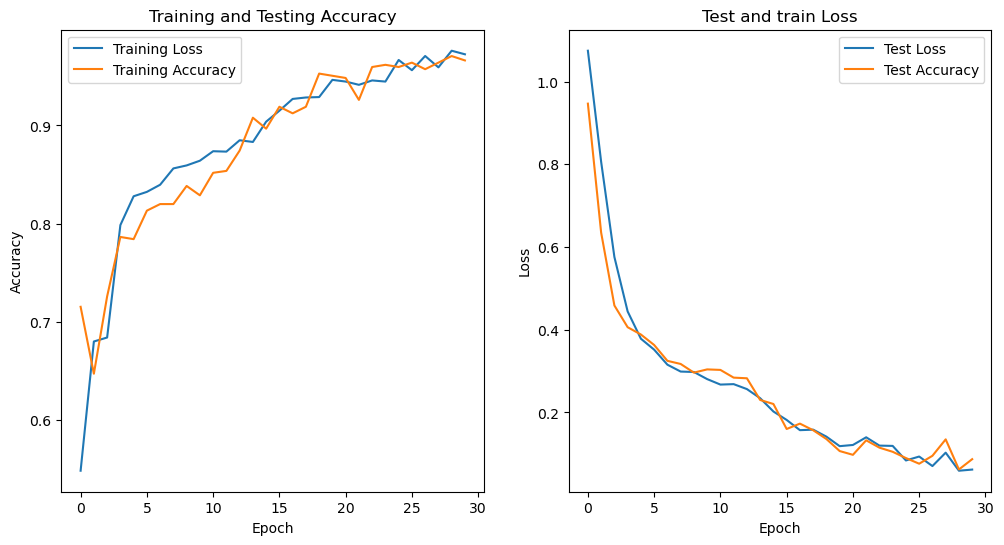

In [28]:
# Create a new figure with a size of (12, 6)
fig = plt.figure(figsize=(12, 6))

# Create a subplot for the training loss and accuracy
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results["train_acc"], label="Training Loss")
ax1.plot(results["test_acc"], label="Training Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training and Testing Accuracy")
ax1.legend()

# Create a subplot for the test loss and accuracy
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results["train_loss"], label="Test Loss")
ax2.plot(results["test_loss"], label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Test and train Loss")
ax2.legend()

# Display the plot
plt.show()

# Test the model

In [35]:
from tqdm.auto import tqdm
def test_model(model, device, test_dataloader):

    # Make predictions on the entire test dataset
    test_preds = []
    model = model.to(device)
    model.eval()
    
    with torch.inference_mode():
      # Loop through the batches in the test dataloader
      for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        # Pass the data through the model
        test_logits = model(X)

        # Convert the pred logits to pred probs
        pred_probs = torch.softmax(test_logits, dim=1)

        # Convert the pred probs into pred labels
        pred_labels = torch.argmax(pred_probs, dim=1)

        # Add the pred labels to test preds list
        test_preds.append(pred_labels)

    # Concatenate the test preds and put them on the CPU
    test_preds = torch.cat(test_preds).cpu()
    return test_preds

In [37]:
# Test the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNPotato().to(device)
model.load_state_dict(torch.load('CNN-potato-disease.pth'))

test_preds = test_model(model, device, test_dataloader)

  0%|          | 0/14 [00:00<?, ?it/s]

In [44]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth
print(len(test_preds))
print(len(test_truth))
print(test_preds.shape, test_truth.shape)

431
431
torch.Size([431]) torch.Size([431])


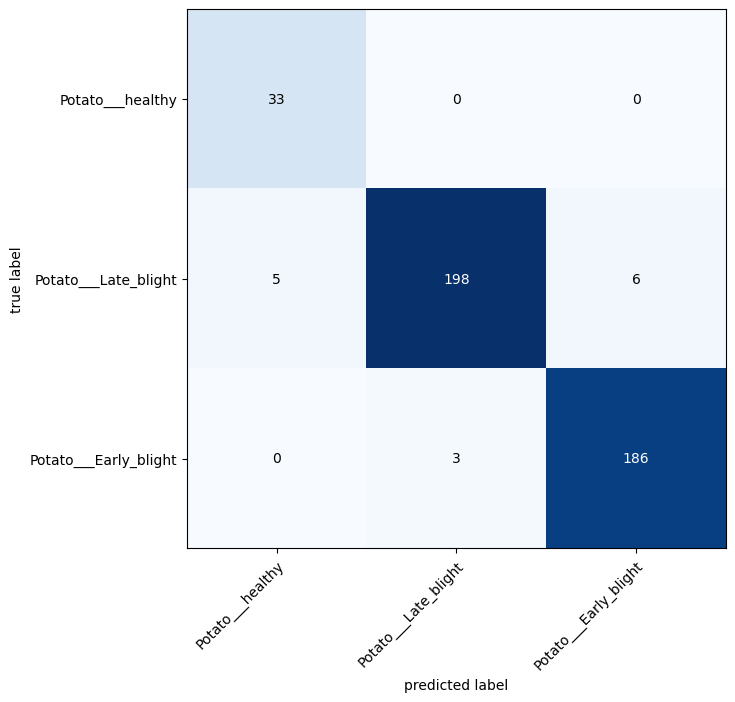

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_name = [i.split('/')[-1] for i in cfg.potato]
# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_name) ,task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_name,
    figsize=(10, 7)
)

# Make prediction or inference on a sample image

In [138]:
def predict_image(image):
    # input is  cv2 image
    image = transforms.ToTensor()(image).unsqueeze(0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CNNPotato().to(device)
    
    model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'CNN-potato-disease.pth'), map_location=torch.device(device)))

    predicted_data = model(image.to(device))
    

    predict_label = torch.argmax(torch.softmax(predicted_data, dim=1))
    confidence = round((torch.softmax(predicted_data, dim=1).max().item() * 100), 2)

    class_name = [i.split('/')[-1] for i in cfg.potato]

    return confidence, predict_label.item(), class_name[predict_label.item()]



In [139]:
path="/kaggle/input/plantvillage-dataset/color/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG"
img = cv2.imread(path)

In [140]:
pred_label = predict_image(img)

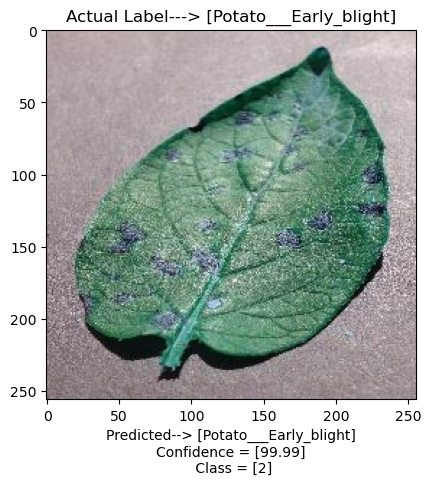

In [154]:
plt.imshow(img)
plt.title(f"Actual Label---> [{path.split('/')[-2]}]")
plt.xlabel(f"Predicted--> [{pred_label[2]}]\nConfidence = [{pred_label[0]}]\n Class = [{pred_label[1]}]")
plt.show()